In [1]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests 
import time

from selenium import webdriver 
from selenium.webdriver.common.keys import Keys 
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from geopy.geocoders import Nominatim
import ast

import warnings
warnings.filterwarnings("ignore")

from my_functions import *

# **1. Merge ``df_masters`` & ``df_ratings``**

In [23]:
# import the dataframes
df_masters = pd.read_csv('Datasets/df_masters.csv')                               # df with all the albums
df_uk_masters = pd.read_csv('Datasets/df_uk_masters.csv')                         # df with all the albums from the UK
df_us_masters = pd.read_csv('Datasets/df_us_masters.csv')                         # df with all the albums from the US
df_blend_ratings = pd.read_csv('Datasets/df_blend_ratings.csv')
df_uk_rock = pd.read_csv('Datasets/df_uk_rock.csv')                               # df with the UK albums (and others) without ratings
df_uk_rock_ratings = pd.read_csv('Datasets/df_uk_rock_ratings.csv')               # df with the UK albums (and others) with ratings
df_ratings_10 = pd.read_csv('Datasets/df_ratings_10.csv', keep_default_na=False)  # albums with >= 10 votes, mostly from rock, worldwide
df_ratings_20 = pd.read_csv('Datasets/df_ratings_20.csv', keep_default_na=False)  # albums with >= 20 votes, mostly from rock, worldwide

# print information
print(f'{df_masters.shape}: df_masters')
print(f'{df_uk_masters.shape}: df_uk_masters')
print(f'{df_us_masters.shape}: df_us_masters')
print(f'{df_blend_ratings.shape}: df_blend_ratings')
print(f'{df_uk_rock.shape}: df_uk_rock')
print(f'{df_uk_rock_ratings.shape}: df_uk_rock_ratings')
print(f'{df_ratings_10.shape}: df_ratings_10')
print(f'{df_ratings_20.shape}: df_ratings_20')

(56660, 13): df_masters
(56660, 13): df_uk_masters
(42811, 13): df_us_masters
(11159, 10): df_blend_ratings
(12060, 13): df_uk_rock
(12059, 10): df_uk_rock_ratings
(79625, 5): df_ratings_10
(51252, 5): df_ratings_20


In [21]:
df_uk_rock[df_uk_rock['artist'].str.contains('Kaleidoscope')]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
4199,407727,23387,892410,UK,Kaleidoscope,Tangerine Dream,1967,0.0,11,"['LP', 'Album', 'Mono']",['Rock'],"['Psychedelic Rock', 'Pop Rock']",English psychedelic folk and rock band existin...
7659,578533,90360,1992861,US,Kaleidoscope,A Beacon from Mars,1967,43.5,8,"['LP', 'Album', 'Stereo']",['Rock'],"['Country Rock', 'Psychedelic Rock']",Active: 1966-1969\r\nFormed/based in Los Angel...
8036,578533,90357,1366219,US,Kaleidoscope,Side Trips,1967,26.1,10,"['LP', 'Album', 'Stereo']",['Rock'],"['Folk Rock', 'Psychedelic Rock']",Active: 1966-1969\r\nFormed/based in Los Angel...
9331,4111105,864459,31350865,US,Kings Kaleidoscope,Becoming Who We Are,2024,0.0,17,"['LP', 'Album', 'Reissue']","['Rock', 'Pop']",[],Kings Kaleidoscope is American alternative roc...


In [4]:
df_uk_rock_ratings[df_uk_rock_ratings['artist'].str.contains('Kaleidoscope')]

,year,artist,title,rating,votes,album_length,tracks,styles,release_country,artist_profile
4199,1967,Kaleidoscope,Tangerine Dream,3.81,43,0.0,11,"['Psychedelic Rock', 'Pop Rock']",UK,English psychedelic folk and rock band existin...
9330,2024,Kings Kaleidoscope,Becoming Who We Are,4.23,44,0.0,17,[],US,Kings Kaleidoscope is American alternative roc...


In [5]:
df_uk_rock[~df_uk_rock['title'].isin(df_uk_rock_ratings['title']).values]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
7659,578533,90360,1992861,US,Kaleidoscope,A Beacon from Mars,1967,43.5,8,"['LP', 'Album', 'Stereo']",['Rock'],"['Country Rock', 'Psychedelic Rock']",Active: 1966-1969\r\nFormed/based in Los Angel...
8036,578533,90357,1366219,US,Kaleidoscope,Side Trips,1967,26.1,10,"['LP', 'Album', 'Stereo']",['Rock'],"['Folk Rock', 'Psychedelic Rock']",Active: 1966-1969\r\nFormed/based in Los Angel...


In [6]:
df_uk_masters.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,364548.0,477687.0,2863713,US,Joey Dee & The Starliters,Back At The Peppermint Lounge / Twistin',1962,0.0,10,"['LP', 'Album', 'Stereo']","['Rock', 'Pop']","['Rock & Roll', 'Twist']",NaN


In [7]:
df_uk_masters['master_id'].isna().sum()

0

In [ ]:
df_uk_masters['master_id'].fillna(0, inplace=True)
df_uk_masters['master_id'].isna().sum()

0

In [24]:
df_masters[df_masters['artist']=='Death']

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


In [25]:
df_uk_masters[df_uk_masters['artist']=='Death']

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


In [26]:
df_uk_masters.head()

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,364548.0,477687.0,2863713,US,Joey Dee & The Starliters,Back At The Peppermint Lounge / Twistin',1962,0.00,10,"['LP', 'Album', 'Stereo']","['Rock', 'Pop']","['Rock & Roll', 'Twist']",NaN
1,318670.0,573548.0,4929189,US,Sandy Nelson,Teenage House Party,1962,28.43,12,"['LP', 'Album', 'Mono']",['Rock'],['Rock & Roll'],"Drummer and session musician, born 1 December ..."
2,192160.0,1707844.0,4051533,UK,Chubby Checker,Twist-A-Long With Chubby Checker,1962,0.00,12,"['LP', 'Album', 'Mono']",['Rock'],"['Rock & Roll', 'Twist']","American rock’n’roll vocalist, best known for ..."
3,318670.0,383656.0,4966722,US,Sandy Nelson,Drummin' Up A Storm,1962,28.52,9,"['LP', 'Album', 'Mono']","['Jazz', 'Rock']","['Rock & Roll', 'Big Band']","Drummer and session musician, born 1 December ..."
4,290122.0,792644.0,11589226,US,Gary U.S. Bonds,Twist Up Calypso,1962,30.65,12,"['LP', 'Album', 'Mono']",['Rock'],"['Twist', 'Rock & Roll', 'Calypso']","Gary U.S. Bonds (born June 6, 1939, Jacksonvil..."


In [27]:
df_uk_masters[df_uk_masters['artist'].str.contains('Death')]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
6482,94647.0,2053.0,381396,US,Christian Death,Only Theatre Of Pain,1982,0.00,10,"['LP', 'Album']",['Rock'],"['Goth Rock', 'Deathrock']",Death Rock band formed in October 1979 - Los A...
7621,203857.0,289771.0,510785,UK,Septic Death,Now That I Have The Attention What Do I Do Wit...,1986,0.00,20,"['LP', 'Album']",['Rock'],"['Hardcore', 'Punk']",American hardcore punk/Ultra-thrash band that ...
7855,2567810.0,516959.0,3706356,UK,Death Mask (2),Split The Atom,1986,36.17,10,"['LP', 'Album']",['Rock'],"['Thrash', 'Speed Metal', 'Heavy Metal']",American Speed/Thrash metal band from New York...
8013,39344.0,10753.0,80041,UK,Death In June,The Wörld Thät Sümmer,1986,66.90,13,"['LP', 'Album']","['Electronic', 'Rock']","['Industrial', 'Darkwave']",Death In June arose in June 1980 from the ashe...
8616,39344.0,424183.0,2063486,UK,Death In June,Symbols And Clouds,2009,116.40,37,"['Compilation', 'Remastered']","['Electronic', 'Rock']","['Industrial', 'Neofolk']",Death In June arose in June 1980 from the ashe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52408,988147.0,914397.0,7827087,US,Ringo Deathstarr,Pure Mood,2015,0.00,12,['Album'],['Rock'],"['Shoegaze', 'Alternative Rock', 'Indie Rock']","Shoegaze band from Austin, TX."
53194,5461022.0,1743982.0,12221088,UK,Birth Struggle Death,Cursed Generation,2018,16.33,7,['Mini-Album'],['Rock'],['Hardcore'],"Hardcore band from Hamburg, Germany"
53354,1502727.0,262838.0,2075011,US,Five Finger Death Punch,The Way Of The Fist,2007,39.03,10,"['Album', 'Stereo']",['Rock'],"['Nu Metal', 'Groove Metal', 'Metalcore']","Heavy metal band from Las Vegas, Nevada, USA. ..."
53606,11614.0,6917.0,1772969,UK,Napalm Death,Order Of The Leech,2002,44.70,12,['Album'],['Rock'],"['Grindcore', 'Death Metal']","Formed in Birmingham, UK in 1982, by Nik Bulle..."


In [18]:
df_us_masters[df_us_masters['artist']=='Death']

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


In [28]:
df_ratings_20[df_ratings_20['artist']=='Death']

,album_id,artist,title,rating,votes
841,1100,Death,Scream Bloody Gore,3.90,2422
1594,2285,Death,The Sound of Perseverance,4.36,3596
1843,2687,Death,Spiritual Healing,3.88,2166
1962,2857,Death,Leprosy,4.10,2488
2909,4257,Death,Individual Thought Patterns,4.31,2840
2910,4258,Death,Symbolic,4.54,4278
2911,4259,Death,Human,4.45,3612
4620,7382,Death,Fate: Best of Death,4.02,68
5598,8892,Death,Live in L.A.: Death and Raw,4.08,174
13377,24200,Death,Live in Eindhoven,4.00,105


In [50]:
df_uk_masters[df_uk_masters['artist'].str.contains('Bob Dylan &')]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


In [51]:
df_us_masters[df_us_masters['artist'].str.contains('Bob Dylan &')]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
7712,2754841.0,0,13774158,US,Bob Dylan & The Band,The Basement Tapes,1975,76.93,24,"['LP', 'Album']",['Rock'],"['Folk Rock', 'Country Rock', 'Classic Rock']",NaN


In [42]:
df_blend_ratings[df_blend_ratings['artist']=='Bob Dylan and The Band']

,year,artist,title,rating,votes,album_length,tracks,styles,release_country,artist_profile
1328,1975,Bob Dylan and The Band,The Basement Tapes,4.04,291,76.93,24,"['Folk Rock', 'Country Rock', 'Classic Rock']",US,NaN


## **Concat with the albums previously cleaned**

In [31]:
df_uk_masters.shape

(56660, 13)

In [32]:
df_us_masters.shape

(42811, 13)

In [33]:
df_concat = pd.concat([df_uk_masters, df_us_masters])
df_concat.shape

(99471, 13)

In [34]:
df_masters = df_concat

## **``df_masters`` parenthesis cleaning from ``artist``**

### Testing

I noticed that some artists in df_masters (so, in the Discogs API) have numbers in parenthesis in the artist name, which won't be merged with df_ratings, where there are almost no artists with numbers in parenthesis

In [59]:
# all the artists in df_masters
df_masters['artist'].nunique()

27045

In [60]:
# show the artists that have characters in parenthesis in the artist name
df_masters_parenthesis = df_masters[df_masters['artist'].str.contains(r'\(.*?\)', regex=True)].sort_values('artist')
df_masters_parenthesis['artist'].nunique()

4816

In [34]:
# print information
print(f'{df_masters.shape}: df_masters')
print(f'{df_masters_parenthesis.shape}: df_masters_parenthesis')

(15584, 13): df_masters
(656, 13): df_masters_parenthesis


In [ ]:
df_ratings_10['artist'].nunique()

23683

In [ ]:
# show the artists that have characters in parenthesis in the artist name
df_ratings_10_parenthesis = df_ratings_10[df_ratings_10['artist'].str.contains(r'\(.*?\)', regex=True)].sort_values('artist')
df_ratings_10_parenthesis['artist'].nunique()

0

In [ ]:
# print information
print(f'{df_ratings_10.shape}: df_ratings_10')
print(f'{df_ratings_10_parenthesis.shape}: df_ratings_10_parenthesis')

(79632, 5): df_ratings_top
(1760, 5): df_ratings_top_parenthesis


In [ ]:
df_ratings_10_parenthesis.sample(5)

,album_id,artist,title,rating,votes
66859,299052,Vacations (AUS),Vibes and Days,3.87,15
66521,293448,Carnation (BE),Chapel of Abhorrence,3.35,40
34007,67551,Soundtrack (Video Game),The Legend of Zelda: Twilight Princess OST,4.23,80
39072,84542,Doom (JPN),Complicated Mind,4.16,25
36362,74638,Tempest (Can),Passages,3.73,37


In most of the artists, the information between parenthesis is the country of origin

In [39]:
# delete these characters
df_masters_parenthesis_clean = df_masters_parenthesis['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()
df_masters_parenthesis_clean

2364       100% Proof
3971       100% Proof
2622     20/20 Vision
1164       38 Special
2445       38 Special
            ...      
3727              XIT
3045            Ya Ya
1735    Youth In Asia
3931              ZED
599              Zeno
Name: artist, Length: 656, dtype: object

In [ ]:
# delete these characters
df_ratings_10_parenthesis_clean = df_ratings_10_parenthesis['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()
df_ratings_10_parenthesis_clean

52533                  
53599                  
35534    Slowest Runner
35487    Slowest Runner
13266              p.e.
              ...      
39716              hide
68464              life
70926              life
49438              sway
68857              オオハシ
Name: artist, Length: 1760, dtype: object

In [ ]:
# merge test, all the artists that coincide on both dataframes after the parenthesis cleaning
pd.merge(df_masters_parenthesis_clean, df_ratings_10_parenthesis_clean, on='artist')

,artist
0,Alaska
1,Alaska
2,Alaska
3,Alaska
4,Attila
...,...
123,X
124,X
125,X
126,X


In [45]:
df_masters[df_masters['artist'].str.contains('Alaska ')]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
1516,594810.0,309057.0,2702245,US,Alaska (8),The Pack,1985,42.32,9,"['LP', 'Album', 'Stereo']",['Rock'],['Hard Rock'],Alaska was a British hard rock band led by Ber...
2990,594810.0,591189.0,1175493,UK,Alaska (8),Heart Of The Storm,1984,0.00,10,"['LP', 'Album']",['Rock'],"['Hard Rock', 'AOR']",Alaska was a British hard rock band led by Ber...


In [ ]:
df_ratings_10[df_ratings_10['artist'].str.contains('Alaska ')]

,album_id,artist,title,rating,votes
48864,135438,Alaska (USA),Everything is Fine,3.38,12
57915,203926,Alaska (USA),Shrine,3.54,12


This shows that for instance **the artist 'Zebra' would not have merged** if we hadn't done that cleaning, because in ``df_masters`` it's registered under **"Zebra (8)"**, and in ``df_ratings`` under **"Zebra (US)"**

### **Let's change the ``artist`` column for good**

In [35]:
df_masters.shape

(99471, 13)

In [36]:
df_masters['artist'] = df_masters['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()

print(f"{df_masters['artist'].nunique()} unique artists in df_masters")

51504 unique artists in df_masters


In [37]:
df_ratings_10['artist'] = df_ratings_10['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()

print(f"{df_ratings_10['artist'].nunique()} unique artists in df_ratings_10")

23683 unique artists in df_ratings_10


## &/and Cleaning

I noticed some artist and/or album names are slightly different, which will cause the merge to not properly function as I intend it.

Notice the difference in the following album: "Behold **and/&** See"

In [80]:
df_ratings_10[df_ratings_10['artist']=="Ultimate Spinach"]

,album_id,artist,title,rating,votes
48951,136113,Ultimate Spinach,Ultimate Spinach,3.81,27
51039,150508,Ultimate Spinach,Behold and See,3.89,23


In [81]:
df_masters[df_masters['artist']=="Ultimate Spinach"]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
2441,407733.0,292196,1382596,US,Ultimate Spinach,Ultimate Spinach,1969,37.83,10,"['LP', 'Album']",['Rock'],['Psychedelic Rock'],"American Psychedelic Rock Band from Boston, Ma..."


In [117]:
df_masters[['artist', 'title']] = df_masters[['artist', 'title']].apply(lambda x: x.str.replace('&', 'and'))
df_ratings_10[['artist', 'title']] = df_ratings_10[['artist', 'title']].apply(lambda x: x.str.replace('&', 'and'))

In [83]:
df_masters[df_masters['artist']=="Ultimate Spinach"]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
2441,407733.0,292196,1382596,US,Ultimate Spinach,Ultimate Spinach,1969,37.83,10,"['LP', 'Album']",['Rock'],['Psychedelic Rock'],"American Psychedelic Rock Band from Boston, Ma..."


## Actual merge

In [38]:
df = pd.merge(
    df_ratings_10.assign(artist_lower=df_ratings_10['artist'].str.lower().str.strip(), 
                      title_lower=df_ratings_10['title'].str.lower().str.strip()), 
    df_masters.assign(artist_lower=df_masters['artist'].str.lower().str.strip(), 
                      title_lower=df_masters['title'].str.lower().str.strip()), 
    on=['artist_lower', 'title_lower']
).drop(columns=['artist_lower', 'title_lower', 'artist_y', 'title_y'])

# Rename columns
df.rename(columns={'artist_x': 'artist', 'title_x': 'title'}, inplace=True)

# Change dtypes
df['master_id'] = df['master_id'].astype(int)

# print the shape
df.shape

(15286, 16)

In [41]:
df[df['artist']=='Bob Dylan and The Band']

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile


In [40]:
df.sample(10)

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
11223,117874,Stereophonics,Graffiti On The Train,3.39,35,12640.0,532770,4377253,UK,2013,43.08,10,['Album'],"['Rock', 'Pop']",['Indie Rock'],"Rock band from Cwmaman, South Wales, formed 19..."
13595,274121,Moose Blood,I Don't Think I Can Do This Anymore,2.61,108,3196662.0,1327809,11663124,UK,2018,36.58,11,"['LP', 'Album']",['Rock'],"['Alternative Rock', 'Pop Punk']","From late Summer 2012, Moose Blood have been f..."
7116,37589,Skullflower,Obsidian Shaking Codex,3.42,13,65697.0,54292,97376,US,1993,73.57,5,['Album'],['Rock'],"['Noise', 'Psychedelic Rock', 'Industrial']",Skullflower formed in London in 1987 as an imp...
12548,191410,Torres,Sprinter,3.65,71,1040289.0,834518,6993353,US,2015,0.00,9,"['LP', 'Album', 'Club Edition']","['Electronic', 'Rock']",['Indie Rock'],"American singer, songwriter, musician and arti..."
1619,5356,Puddle of Mudd,Come Clean,2.70,471,262019.0,135368,2873060,US,2001,48.10,11,['Album'],['Rock'],"['Alternative Metal', 'Post-Grunge']",Alternative Rock (Modern Rock) band formed in ...
7110,37579,The Doobie Brothers,Toulouse Street,3.71,39,37223.0,95279,2406791,US,1972,35.55,10,"['LP', 'Album', 'Stereo']",['Rock'],"['Pop Rock', 'Gospel', 'Southern Rock']",Blue eyed soul - roots rock band.\r\n\r\nForme...
3449,11769,Marillion,Seasons End,3.74,160,218108.0,16360,794255,Europe,1989,47.13,8,"['LP', 'Album', 'Stereo']",['Rock'],"['Symphonic Rock', 'Prog Rock']","Marillion formed in Aylesbury, Buckinghamshire..."
73,188,Iced Earth,Burnt Offerings,4.22,737,261489.0,107910,1095349,Germany,1995,52.58,11,['Album'],['Rock'],"['Thrash', 'Heavy Metal']",American heavy metal band formed in 1984 that ...
13083,226565,Angel,Helluva Band,3.65,10,434871.0,162541,1868448,Canada,1976,43.90,9,"['LP', 'Album']",['Rock'],['Hard Rock'],"Glam/hard rock band from Washington, D.C., USA..."
13835,301169,Portrayal of Guilt,Let Pain Be Your Guide,3.71,256,5776784.0,1455166,12827871,US,2018,22.25,10,['MP3'],['Rock'],"['Post-Hardcore', 'Emo', 'Hardcore']",American hardcore / black metal / screamo band...


In [ ]:
df['release_country'].value_counts().head(10)

release_country
US                 5776
UK                 4375
Europe             1729
UK & Europe         513
Germany             421
Canada              260
UK, Europe & US     182
Australia           177
Worldwide           137
USA & Canada        111
Name: count, dtype: int64

In [124]:
print(f"{round(df.shape[0] / df_masters.shape[0]*100, 2)} % of the albums have ratings")

17.0 % of the albums have ratings


### First inspection

**Change the dtype of ``artist_id``**

In [125]:
df[df['artist_id'].isna()]

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
1019,3112,Bruce Springsteen,Darkness on the Edge of Town,4.27,749,NaN,0,4125934,UK,1978,0.00,10,"['LP', 'Album']",['Rock'],"['Acoustic', 'Classic Rock']",NaN
1280,4035,Queen,News of the World,3.88,908,NaN,0,3686544,UK,1977,0.00,11,"['LP', 'Album']",['Rock'],"['Hard Rock', 'Pop Rock']",NaN
1936,6700,UFO,Strangers In The Night,4.54,136,NaN,0,4245362,UK,1979,73.07,13,"['LP', 'Album']",['Rock'],"['Hard Rock', 'Space Rock', 'Heavy Metal']",NaN
3354,12216,Prince,Graffiti Bridge,3.09,110,NaN,0,4356837,US,1990,68.38,17,"['LP', 'Album']","['Electronic', 'Funk / Soul', 'Rock', 'Stage &...","['Soundtrack', 'Pop Rock', 'Synth-pop', 'Funk']",NaN
5069,23029,Roxy Music,Roxy Music,4.00,259,NaN,0,4136782,UK,1972,42.25,9,"['LP', 'Album']","['Electronic', 'Rock']","['Art Rock', 'Experimental', 'Glam']",NaN
8156,56777,David Bowie,Changesonebowie,4.16,41,NaN,0,6686216,UK,1976,46.13,11,['Album'],['Rock'],"['Pop Rock', 'Soul', 'Glam']",NaN


In [37]:
df[df['artist']=='George Michael'].sample(2)

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
7052,72484,George Michael,Older,4.00,77,NaN,0,6272825,UK,1996,58.72,11,"['Album', 'Promo']","['Electronic', 'Jazz', 'Rock']","['Downtempo', 'Synth-pop', 'Contemporary Jazz']",NaN
956,4070,George Michael,Faith,3.66,142,32990.0,96689,413315,Europe,1987,47.52,9,"['LP', 'Album', 'Stereo']","['Electronic', 'Rock', 'Funk / Soul', 'Pop']","['Soft Rock', 'Pop Rock']","George Michael (born 25 June 1963, East Finchl..."


In [81]:
df.loc[7046, 'artist_id'] = 32990

In [ ]:
df['artist_id'] = df['artist_id'].astype(int)
df.head(1)

**Sort columns**

I want to see the ``year`` next to the album ``title``, and I don't care much about the ``ids``

In [126]:
df = columns_show_ratings(df)
df.head(1)

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
0,40,Sparta,Wiretap Scars,2002,3.79,431,47.62,12,US,['Album'],['Rock'],"['Indie Rock', 'Alternative Rock']","El Paso, Texas based band. Formed in 2001 afte...",253712.0,158153,426893


**I keep only rock albums**

In [127]:
df.shape

(14830, 16)

In [128]:
# how many of them are Rock albums?
df = df[df['genres'].str.contains('Rock')]
df.shape

(14476, 16)

**Drop compilations**

In [134]:
df['release_type'].isna().sum()

0

In [131]:
df['release_type'].value_counts().head(10)

release_type
['Album']                             5753
['LP', 'Album']                       4100
['LP', 'Album', 'Stereo']             1639
['LP', 'Album', 'Limited Edition']     545
['Album', 'Stereo']                    355
['Album', 'Enhanced']                  179
['LP', 'Album', 'Mono']                154
['Album', 'Limited Edition']           153
['LP']                                 126
['FLAC', 'Album']                      102
Name: count, dtype: int64

In [130]:
df[df['release_type'].isna()]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
1112,3415,3 Doors Down,Seventeen Days,2005,2.65,375,51.7,14,US,NaN,['Rock'],['Alternative Rock'],"Alternative Rock (Modern Rock) from Escatawpa,...",166483.0,89121,512748
9236,75222,Fireworks,Gospel,2011,3.85,331,0.0,12,US,NaN,['Rock'],"['Punk', 'Pop Rock']","American pop-punk band from Metro Detroit, Mic...",1922447.0,378800,4088584


In [138]:
df.sample()

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
12293,207312,The Cult,Hidden City,2016,3.45,43,52.43,12,"USA, Canada & UK",['Album'],['Rock'],['Hard Rock'],British rock band formed as [a=Death Cult] in ...,15266.0,954177,8067928


In [153]:
# it's an american band, so I can just drop it
df.loc[1112, 'release_type'] = 'Album'
df.loc[9236, 'release_type'] = 'Album'
df['release_type'].isna().sum()

0

In [159]:
print(df['release_type'].dtype)

object


In [160]:
type(df.release_type[0])

str

In [158]:
print(f'There are {df[df['release_type'].str.contains('Compilation')].shape[0]} compilations')

There are 71 compilations


In [161]:
df = df[~df['release_type'].str.contains('Compilation')]
df.shape

(14405, 16)

In [164]:
# number of unique artists
df['artist'].nunique()

5646

**YOB** té **8** albums a Sputnik (``df_ratings_20``), però nomes **2** a Discogs de UK, tot i que és una banda de UK. 

Si apareixen al df de US, hauré de fer un concat/merge

In [165]:
df[df['artist']=='YOB']

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
8360,60241,YOB,Catharsis,2003,3.99,140,49.07,3,US,['Album'],['Rock'],['Doom Metal'],Yob is an American stoner/doom metal band from...,563922.0,129480,2806549
11657,163668,YOB,Clearing The Path To Ascend,2014,3.92,331,62.53,4,US,['Album'],['Rock'],"['Doom Metal', 'Sludge Metal']",Yob is an American stoner/doom metal band from...,563922.0,729329,6054020


In [168]:
df_ratings_20[df_ratings_20['artist']=='YOB']

,album_id,artist,title,rating,votes
2485,3646,YOB,The Illusion Of Motion,3.94,183
15507,29146,YOB,The Unreal Never Lived,4.06,225
19335,39606,YOB,The Great Cessation,3.90,205
24401,60240,YOB,Elaborations Of Carbon,3.42,73
24402,60241,YOB,Catharsis,3.99,140
28092,80046,YOB,Atma,3.78,259
36277,163668,YOB,Clearing The Path To Ascend,3.92,331
43372,282109,YOB,Our Raw Heart,3.87,295


## ``df`` real cleaning

I want to **drop duplicates** and releases from **bands outside of the UK**, I only want to keep brittish artists. Also **drop compilations and live albums**.

**Deleting artists from outside the UK**

In [ ]:
# delete_non_uk_artists(df)

Initial artists: 5094
Final artists: 5094


### Drop duplicates

In [218]:
df.sort_values('master_id', inplace=True, ascending=False) # so I keep the master_id=0 at the end, these would be the duplicates and I'll be able to drop them
df.reset_index(drop=True, inplace=True)
df[['artist', 'title', 'year', 'rating', 'votes', 'album_length', 'tracks']].duplicated().sum()

62

In [ ]:
# these albums are the same, except one entry has master_id=0
print(df.shape)
df.drop_duplicates(subset=['artist', 'title', 'year', 'rating', 'votes', 'album_length', 'tracks'], inplace=True)
print(df.shape)

(14343, 16)

In [226]:
df[df[['artist', 'title']].duplicated()]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
586,99027,Toad,Toad,1971,3.96,12,0.00,7,Italy,"['LP', 'Album']",['Rock'],['Hard Rock'],Swiss rock group.,1233714.0,2638964,3320280
1177,452596,Panchiko,D>E>A>T>H>M>E>T>A>L,2020,3.79,29,48.27,11,UK,"['FLAC', 'Reissue', 'Remastered']","['Electronic', 'Rock', 'Pop']","['Indie Pop', 'Indie Rock']","Four-piece band from Nottingham, UK formed in ...",5949697.0,1684911,15106255
1241,338530,Stake,Critical Method,2019,3.54,13,0.00,8,NaN,"['LP', 'Album']",['Rock'],[],Originally started in as [a=Steak Number Eight...,7172650.0,1628296,14330782
3274,197266,Embrace,Embrace,2014,3.35,10,46.38,10,Europe,['Album'],"['Rock', 'Pop']","['Indie Rock', 'Indie Pop']","English post-Britpop band from Bailiff Bridge,...",236112.0,682568,5705404
4014,111675,Metz,Metz,2012,3.61,209,0.00,11,US,['Album'],['Rock'],"['Grunge', 'Punk', 'Noise Rock']",METZ (official capitalization) is a noise rock...,1333275.0,479017,3953119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14380,214752,Tempest,Tempest,1984,3.88,25,18.62,6,US,"['LP', 'Album', 'Stereo']",['Rock'],"['Hard Rock', 'Pop Rock']",NaN,5056224.0,0,8538126
14383,24454,Marianne Faithfull,Broken English,1979,3.93,67,0.00,8,UK,"['LP', 'Album']",['Rock'],"['Art Rock', 'Classic Rock']","Born: 29th December 1946, in Hampstead, London...",62391.0,0,15204616
14385,331848,Frog,Frog,1994,4.10,10,0.00,10,US,"['Album', 'Stereo']",['Rock'],['Punk'],NaN,166353.0,0,29349841
14390,228206,Ground Zero,Ground Zero,1987,3.80,10,34.75,9,US,"['LP', 'Album']",['Rock'],[],NaN,11983469.0,0,11723126


In [232]:
df[df['title']=='Broken English']

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
10093,24454,Marianne Faithfull,Broken English,1979,3.93,67,37.07,8,UK,"['LP', 'Album', 'Stereo']",['Rock'],['Art Rock'],"Born: 29th December 1946, in Hampstead, London...",62391.0,57119,496471
14383,24454,Marianne Faithfull,Broken English,1979,3.93,67,0.00,8,UK,"['LP', 'Album']",['Rock'],"['Art Rock', 'Classic Rock']","Born: 29th December 1946, in Hampstead, London...",62391.0,0,15204616


**Check these duplicated albums in the original dataframes**

In [105]:
# to see the difference between the duplicated albums searching for the album name
df[df['title']=="Master Of Reality"].sort_values('year')

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
169,620,Black Sabbath,Master Of Reality,1971,4.45,3756,34.48,8,UK,"['LP', 'Album', 'Stereo']",['Rock'],"['Heavy Metal', 'Doom Metal']",Considered by many to be the first heavy metal...,144998,4844,590773


**Drop incorrect albums**

In [102]:
# check one by one if necessary
try:
    df.drop([170], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")
    print(df.shape)

Rows dropped
(12060, 16)


**Change specific values that are wrong/missing**

In [104]:
# change specific values that are wrong/missing

# df.loc[1615, 'title'] = 'Heroes'
# df.loc[8365, 'rating'] = 3.62
# df.loc[8365, 'votes'] = 13
df.loc[169, 'album_length'] = 34.48
# df.loc[8002, 'tracks'] = 14

In [103]:
# calculate the decimals of the album length (seconds)
29/60

0.48333333333333334

**``df_ratings_top``**

If there are two albums with the same name, but one is for instance an EP or a compilation I don't want to keep, I have to drop it from df,

but also from df_ratings_top, otherwise I will keep running into this duplicated album every time I add more albums

In [ ]:
df_ratings_20[df_ratings_20['artist']=='New York Dolls']

,album_id,artist,title,rating,votes
3641,5562,New York Dolls,New York Dolls,3.97,386
5723,8501,New York Dolls,Too Much Too Soon,3.77,127
7343,10865,New York Dolls,One Day It Will Please Us To Remember...,3.06,52
33313,65305,New York Dolls,Rock'n Roll,4.00,11
36149,74079,New York Dolls,Cause I Sez So,2.71,29
36150,74083,New York Dolls,Dancing Backward In High Heels,2.35,24


In [ ]:
df_ratings_20[df_ratings_20['title']=='Animal Tracks']

,album_id,artist,title,rating,votes
19213,30855,The Animals,Animal Tracks,3.68,11


In [ ]:
# check one by one if necessary
try:
    df_ratings_20.drop([4853], axis=0, inplace=True)
    print('Rows dropped')
    print(df_ratings_20.shape)
except:
    print("Couldn't drop these rows")
    print(df_ratings_20.shape)

Rows dropped
(79626, 5)


In [ ]:
# df_ratings_20.to_csv('Datasets/df_ratings_20.csv', index=False)

### **Drop live albums**

Let's try to detect the live albums by the title

**'Live at'**

In [237]:
df.shape

(14343, 16)

In [238]:
print(f"There are {df[df['title'].str.contains('Live at ', case=False)].shape[0]} albums with 'Live at ' in the title")

There are 29 albums with 'Live at ' in the title


In [239]:
# Let's check them before deleting them
df[df['title'].str.contains('Live at ', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
690,413051,Anna von Hausswolff,Live at Montreux Jazz Festival,2022,4.27,43,59.63,6,"UK, Europe & US",['Album'],"['Rock', 'Classical']",[],"Swedish singer, pianist, organist and songwrit...",1724854.0,2470054,21778390
1221,341452,IDLES,A Beautiful Thing: Idles Live At Le Bataclan,2019,4.15,24,0.00,21,Worldwide,['Album'],['Rock'],"['Punk', 'Post-Punk']","British heavy indie/punk band from Bristol, Lo...",2890530.0,1645355,14475294
2190,238704,Bring Me The Horizon,Live at the Royal Albert Hall,2016,3.89,91,0.00,15,Europe,"['Album', 'Limited Edition']",['Rock'],"['Symphonic Rock', 'Post-Hardcore']","Metalcore band from Sheffield, Yorkshire, UK, ...",1253307.0,1105195,9480833
2194,236884,Enter Shikari,Live At Alexandra Palace,2016,4.19,16,0.00,16,UK,"['LP', 'Album']","['Electronic', 'Rock']","['Alternative Rock', 'Hardcore']",Enter Shikari are an English four-piece rock b...,652888.0,1096780,9381289
2985,182112,King Crimson,Live at the Orpheum,2015,3.38,21,81.87,14,"UK, Europe & US",['Album'],['Rock'],"['Prog Rock', 'Art Rock']",were an English-based progressive rock band fo...,70828.0,784639,6528463
3003,68348,Ten Years After,Live at the Fillmore East 1970,2001,4.30,10,114.45,12,Europe,['Album'],"['Rock', 'Blues']","['Blues Rock', 'Rock & Roll']",Ten Years After is a British blues and blues r...,253987.0,769839,7758916
3110,168442,Queen,Live at the Rainbow '74,2014,4.52,42,144.15,43,Europe,['Album'],['Rock'],[],Queen is a British rock band formed in London ...,81013.0,729723,6058985
3605,135687,The Allman Brothers Band,Live at Ludlow Garage 1970,1990,4.46,12,91.15,8,Europe,['Album'],"['Rock', 'Blues']",[],American rock / blues band once based in Macon...,110253.0,580557,4778495
3840,46328,Derek and the Dominos,Live at the Fillmore,1994,3.89,22,122.02,13,US,"['Album', 'Remastered']","['Rock', 'Blues']","['Blues Rock', 'Electric Blues', 'Classic Rock']",Blues rock band formed in the spring of 1970 a...,110252.0,522124,10681728
4266,72449,Iron Maiden,Live At The Rainbow,1981,4.22,38,0.00,7,UK,"['Stereo', 'PAL']",['Rock'],['Heavy Metal'],"English heavy metal band formed in Leyton, Eas...",251595.0,435450,2181680


In [240]:
# correct, they are all live albums
df = df[~df['title'].str.contains('Live at ', case=False)]
df.shape

(14314, 16)

**'Live in'**

In [241]:
print(f"There are {df[df['title'].str.contains(r'^Live in ', case=False)].shape[0]} albums with 'Live in ' in the title")

There are 14 albums with 'Live in ' in the title


In [242]:
# Let's check them before deleting them
df[df['title'].str.contains(r'^Live in ', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
906,343998,King Gizzard and The Lizard Wizard,Live In Paris '19,2020,3.65,13,92.72,19,Australia,"['FLAC', 'Album']",['Rock'],['Psychedelic Rock'],"Psychedelic rock band from Melbourne, Victoria...",2532180.0,2013943,14648909
1745,266707,King Crimson,Live in Chicago,2017,4.08,12,155.75,21,UK,"['Album', 'Special Edition']",['Rock'],"['Prog Rock', 'Art Rock']",were an English-based progressive rock band fo...,70828.0,1343890,11004503
3010,188619,Leonard Cohen,Live In Dublin,2014,4.23,11,180.28,67,Europe,['Album'],"['Rock', 'Pop', 'Folk, World, & Country']",['Pop Rock'],"Leonard Cohen was born September 21,1934, in M...",227848.0,766210,6371471
4078,155304,Supertramp,Live In Paris '79,2012,4.53,18,0.00,25,Europe,"['Stereo', 'Multichannel']","['Rock', 'Pop']","['Soft Rock', 'Pop Rock', 'Prog Rock']","British/American rock band formed in London, E...",251517.0,466938,3837154
4894,101195,Rainbow,Live In Munich 1977,2006,4.55,49,98.68,8,Europe,['Album'],['Rock'],['Hard Rock'],Rainbow (also known as Ritchie Blackmore's Rai...,245648.0,349143,1857927
5701,23868,Lou Reed,Live in Italy,1984,3.69,16,73.10,14,UK & Europe,"['LP', 'Album', 'Stereo']",['Rock'],"['Blues Rock', 'Rock & Roll', 'Avantgarde']","American musician, songwriter, poet, and photo...",11879.0,269218,980101
7332,28578,Echo and The Bunnymen,Live In Liverpool,2002,3.87,15,0.00,17,UK & Europe,['Album'],['Rock'],"['Alternative Rock', 'Pop Rock']",Formed in Liverpool in 1978. The original line...,45115.0,145826,1247082
8788,13431,Helloween,Live In The U.K.,1989,3.98,63,47.33,7,Europe,['Album'],['Rock'],"['Heavy Metal', 'Power Metal']","Power metal band from Hamburg, Germany.\r\n\r\...",252425.0,90592,369372
9357,5904,John Lennon,Live In New York City,1986,3.29,29,42.17,11,UK,"['LP', 'Album', 'Stereo']",['Rock'],['Rock & Roll'],"Songwriter, rock singer and guitar player, bes...",46481.0,73035,570663
9848,101193,Rainbow,Live In Germany 1976,1990,4.06,18,99.62,8,UK,['Album'],['Rock'],['Hard Rock'],Rainbow (also known as Ritchie Blackmore's Rai...,245648.0,62410,1307968


In [243]:
# I can drop them all
df = df[~df['title'].str.contains(r'^Live in ', case=False)]
df.shape

(14300, 16)

In [245]:
# This is a studio album
df[df['title'].str.contains('Live in ', case=True)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
3628,42478,Panic! at the Disco,...Live in Chicago,2008,3.21,59,72.32,27,Europe,[],['Rock'],"['Pop Punk', 'Pop Rock']","American rock band from Las Vegas, Nevada. US\...",553643.0,573038,3477215
3903,54126,Entombed,Monkey Puss (Live in London),1998,3.14,14,46.80,10,UK,['Album'],['Rock'],['Death Metal'],"Death metal band from Stockholm, Sweden, forme...",233606.0,510120,1929955
6227,16841,Low,I Could Live in Hope,1994,4.12,533,57.08,11,US,['Album'],['Rock'],['Slowcore'],"American indie rock group from Duluth, Minneso...",10824.0,225930,545527


### **Dropping compilations sorting albums by the top rated**

Usually compilations have the best songs of the band and users love them, so let's find them, even if 'Compilation' is not in ``release_type``

In [246]:
start_row = 0

df.sort_values(['votes'], ascending=False).iloc[start_row:start_row+10]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
12629,1484,Radiohead,OK Computer,1997,4.54,9186,0.00,16,Worldwide,"['LP', 'Album']","['Electronic', 'Rock']",['Alternative Rock'],Electronic and alternative rock (modern rock) ...,3840.0,21491,4950798
13694,116,Metallica,Master Of Puppets,1986,4.45,8950,54.00,8,US,"['LP', 'Album']",['Rock'],"['Thrash', 'Speed Metal']",Thrash Metal (Heavy Metal) band from Los Angel...,18839.0,6495,1549636
13386,130,Pink Floyd,The Dark Side Of The Moon,1973,4.55,8048,0.00,10,UK,"['LP', 'Album', 'Stereo']",['Rock'],"['Prog Rock', 'Psychedelic Rock']",Pink Floyd was an English rock band from Londo...,45467.0,10362,1873013
13703,222,Metallica,Ride The Lightning,1984,4.42,8013,47.33,8,US,"['LP', 'Album']",['Rock'],"['Thrash', 'Speed Metal']",Thrash Metal (Heavy Metal) band from Los Angel...,18839.0,6440,377464
12626,226,Radiohead,Kid A,2000,4.43,7685,46.72,15,UK,"['10""', '33 ⅓ RPM', 'Album', 'Stereo']","['Electronic', 'Rock']","['Alternative Rock', 'IDM', 'Experimental']",Electronic and alternative rock (modern rock) ...,3840.0,21501,74743
13687,281,Metallica,...And Justice For All,1988,4.19,7312,65.17,9,US,"['LP', 'Album', 'Stereo']",['Rock'],"['Thrash', 'Heavy Metal']",Thrash Metal (Heavy Metal) band from Los Angel...,18839.0,6571,521407
13677,3015,Metallica,Metallica,1991,3.70,7285,62.27,12,US,['Album'],['Rock'],['Heavy Metal'],Thrash Metal (Heavy Metal) band from Los Angel...,18839.0,6651,4319735
14129,92,Tool,Lateralus,2001,4.45,7254,78.85,13,US,"['HDCD', 'Album']",['Rock'],"['Progressive Metal', 'Prog Rock', 'Heavy Metal']",Tool is an American rock band from Los Angeles...,87016.0,1517,7325426
13131,471,Nirvana,Nevermind,1991,4.07,7191,42.53,12,US,"['Album', 'Mispress']",['Rock'],['Grunge'],"Rock band from Aberdeen, Washington, USA, form...",125246.0,13814,367084
13320,531,Pink Floyd,Wish You Were Here,1975,4.63,7065,0.00,5,UK,"['LP', 'Album', 'Stereo']",['Rock'],['Prog Rock'],Pink Floyd was an English rock band from Londo...,45467.0,11703,16211812


In [325]:
# check one by one if necessary
try:
    df.drop([9140], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")
    print(df.shape)

Rows dropped
(11739, 16)


### **Drop ratings and sort columns**

In [247]:
df = columns_hide_ratings(df)

In [248]:
df_masters.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,364548.0,477687.0,2863713,US,Joey Dee and The Starliters,Back At The Peppermint Lounge / Twistin',1962,0.0,10,"['LP', 'Album', 'Stereo']","['Rock', 'Pop']","['Rock & Roll', 'Twist']",NaN


In [249]:
df.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368.0,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.0,8,"['LP', 'Album']",['Rock'],['Post-Hardcore'],"Post-screamo band from Brighton, UK\r\n"


In [251]:
df['artist'].nunique()

5645

In [250]:
df['artist_id'] = df['artist_id'].astype(int)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

### **``year = 0``**

In [ ]:
# df = pd.read_csv('Datasets/df_uk_rock_ratings.csv')
# df.shape

(11752, 13)

In [252]:
df[df['year']==0].shape

(59, 13)

In [253]:
df[df['year']==0].head()

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
907,1895939.0,2012653,17730970,UK,Heights,Dead Ends,0,36.75,10,"['Album', 'Promo']",['Rock'],"['Emo', 'Hardcore', 'Heavy Metal']",NaN
1481,1894703.0,1500155,11104869,UK,Sacred Mother Tongue,The Ruin Of Man,0,0.00,13,['Album'],['Rock'],['Heavy Metal'],Four-piece British heavy metal band from North...
1883,1158584.0,1262896,1793856,UK,The Pineapple Thief,Abducting the Unicorn,0,68.07,10,"['Album', 'Reissue']",['Rock'],"['Art Rock', 'Prog Rock']",The Pineapple Thief is the musical vision of [...
3232,3482126.0,694194,3715326,Denmark,The Last Things,Circles and Butterflies,0,47.95,11,"['Album', 'Reissue']",['Rock'],"['Prog Rock', 'Heavy Metal', 'Power Metal']",NaN
4360,534926.0,421130,1311041,UK,Frank Turner,Sleep Is For The Week,0,0.00,13,"['Album', 'Reissue']",['Rock'],['Indie Rock'],English punk and folk singer-songwriter from M...


In [ ]:
# df.loc[6659, 'year'] = 1971

In [28]:
# check one by one if necessary
try:
    df.drop([1434], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")
    print(df.shape)

Rows dropped
(11682, 13)


### **Export to csv**

In [255]:
df.to_csv('Datasets/df_blend_test.csv', index=False)

<Axes: xlabel='count', ylabel='year'>

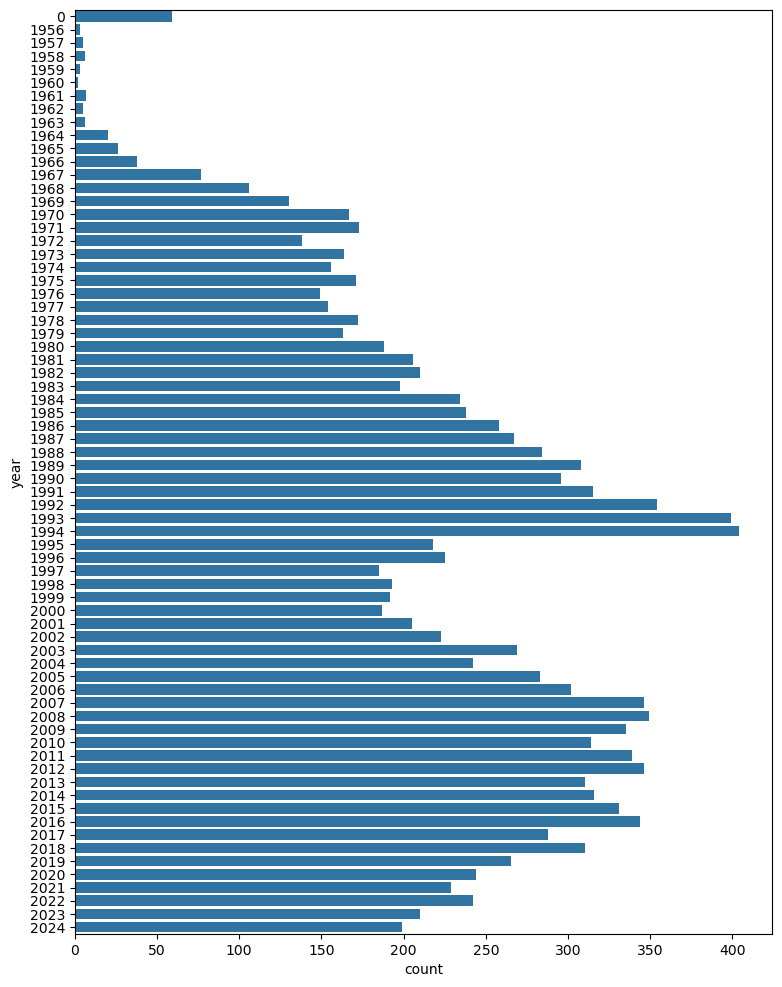

In [254]:
plt.figure(figsize=(9,12))
sns.countplot(data=df, y='year')

# **``df_uk_rock`` merge with ratings and cleaning**

In [258]:
# import the dataframes
df_blend_test = pd.read_csv('Datasets/df_blend_test.csv')                                 # df with the albums already cleaned
df_ratings_20 = pd.read_csv('Datasets/df_ratings_20.csv', keep_default_na=False)  # all ratings, mostly from rock, worldwide

# print information
print(f'{df_blend_test.shape}: df_blend_test')
print(f'{df_ratings_20.shape}: df_ratings_20')

(14300, 13): df_blend_test
(51252, 5): df_ratings_20


In [259]:
df_blend_test.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368.0,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.0,8,"['LP', 'Album']",['Rock'],['Post-Hardcore'],"Post-screamo band from Brighton, UK\r\n"


## Dropping columns

In [260]:
df_blend_test.release_type.value_counts().head()

release_type
['Album']                             5732
['LP', 'Album']                       4052
['LP', 'Album', 'Stereo']             1625
['LP', 'Album', 'Limited Edition']     545
['Album', 'Stereo']                    355
Name: count, dtype: int64

In [261]:
# I can drop it, as well as other columns
df_blend_test.drop(columns=['artist_id', 'master_id', 'main_release_id', 'release_type', 'genres'], inplace=True)
df_blend_test.head(1)

,release_country,artist,title,year,album_length,tracks,styles,artist_profile
0,NaN,As Living Arrows,Hope and Ruin,2024,0.0,8,['Post-Hardcore'],"Post-screamo band from Brighton, UK\r\n"


## Merge with ``df_ratings_top``

In [262]:
# print information
print(f'{df_blend_test.shape}: df_blend_test')
print(f'{df_ratings_20.shape}: df_ratings_20')

(14300, 8): df_blend_test
(51252, 5): df_ratings_20


In [263]:
df = pd.merge(
    df_ratings_20.assign(artist_lower=df_ratings_20['artist'].str.lower().str.strip(), 
                      title_lower=df_ratings_20['title'].str.lower().str.strip()), 
    df_blend_test.assign(artist_lower=df_blend_test['artist'].str.lower().str.strip(), 
                      title_lower=df_blend_test['title'].str.lower().str.strip()), 
    on=['artist_lower', 'title_lower']
).drop(columns=['artist_lower', 'title_lower', 'artist_y', 'title_y'])

# rename columns
df.rename(columns={'artist_x': 'artist', 'title_x': 'title'}, inplace=True)

# drop columns
df.drop(columns=['album_id'], inplace=True)

# print the shape
df.shape

(11159, 10)

In [264]:
df[df[['artist', 'title']].duplicated()]

,artist,title,rating,votes,release_country,year,album_length,tracks,styles,artist_profile
75,Led Zeppelin,Led Zeppelin,4.25,4088,UK,1969,39.75,9,"['Blues Rock', 'Hard Rock']",The English rock band Led Zeppelin was active ...
144,The Who,Tommy,4.08,1357,UK,1969,76.60,24,"['Rock Opera', 'Classic Rock']","English rock band formed in Hammersmith, Londo..."
187,Weezer,Weezer,4.36,4264,US,1994,41.30,10,"['Alternative Rock', 'Pop Rock', 'Pop Punk']","Rock band from Los Angeles, California, US.\r\..."
278,King Crimson,Larks' Tongues in Aspic,4.29,1603,UK,1973,46.62,6,"['Prog Rock', 'Experimental']",were an English-based progressive rock band fo...
301,Bob Dylan,Blood on the Tracks,4.45,1586,US,1975,51.67,10,"['Folk Rock', 'Acoustic', 'Ballad']","Born: May 24, 1941, Duluth, Minnesota, USA; si..."
...,...,...,...,...,...,...,...,...,...,...
9628,Toad,Toad,3.81,27,Italy,1971,0.00,7,['Hard Rock'],Swiss rock group.
10392,Panchiko,D>E>A>T>H>M>E>T>A>L,3.62,69,UK,2020,48.27,11,"['Indie Pop', 'Indie Rock']","Four-piece band from Nottingham, UK formed in ..."
10396,Jerry Garcia,Garcia,4.14,28,US,1972,40.07,10,"['Folk Rock', 'Psychedelic Rock']","Guitar, Banjo, pedal steel guitar and vocals.\..."
10916,Panchiko,D>E>A>T>H>M>E>T>A>L,3.79,29,UK,2020,48.27,11,"['Indie Pop', 'Indie Rock']","Four-piece band from Nottingham, UK formed in ..."


In [265]:
df[df.duplicated()]

,artist,title,rating,votes,release_country,year,album_length,tracks,styles,artist_profile
3421,Embrace,Embrace,3.99,309,Europe,2014,46.38,10,"['Indie Rock', 'Indie Pop']","English post-Britpop band from Bailiff Bridge,..."
3423,Embrace,Embrace,3.99,309,US,1987,0.00,14,"['Emo', 'Hardcore']","Embrace was short-lived band from Washington, ..."
3857,Drowning Pool,Drowning Pool,2.53,49,US,1987,0.00,9,"['Art Rock', 'Goth Rock', 'Avantgarde', 'Exper...",Drowning Pool was an avant-rock ensemble that ...
4713,Evanescence,Evanescence,3.46,75,UK & Europe,2011,47.28,12,['Alternative Rock'],Alternative Rock / Modern Rock band founded in...
6806,Drowning Pool,Drowning Pool,2.81,168,US,1987,0.00,9,"['Art Rock', 'Goth Rock', 'Avantgarde', 'Exper...",Drowning Pool was an avant-rock ensemble that ...
7903,Evanescence,Evanescence,3.13,502,UK & Europe,2011,47.28,12,['Alternative Rock'],Alternative Rock / Modern Rock band founded in...
9628,Toad,Toad,3.81,27,Italy,1971,0.00,7,['Hard Rock'],Swiss rock group.
10392,Panchiko,D>E>A>T>H>M>E>T>A>L,3.62,69,UK,2020,48.27,11,"['Indie Pop', 'Indie Rock']","Four-piece band from Nottingham, UK formed in ..."
10917,Panchiko,D>E>A>T>H>M>E>T>A>L,3.79,29,UK,2020,48.27,11,"['Indie Pop', 'Indie Rock']","Four-piece band from Nottingham, UK formed in ..."


In [48]:
df[df['title']=='Animal Tracks']

,year,artist,title,rating,votes,album_length,tracks,styles,release_country,artist_profile
4644,1965,The Animals,Animal Tracks,3.68,11,0.0,11,['Rhythm & Blues'],UK,British blues rock band formed in the early 19...
4645,1965,The Animals,Animal Tracks,3.60,10,0.0,11,['Rhythm & Blues'],UK,British blues rock band formed in the early 19...


In [52]:
df_ratings_top[df_ratings_top['title']=='Animal Tracks']

,album_id,artist,title,rating,votes
19213,30855,The Animals,Animal Tracks,3.68,11


In [50]:
df_ratings_top.shape

(79626, 5)

In [51]:
df_ratings_top.drop([19214], inplace=True)
df_ratings_top.shape

(79625, 5)

In [11]:
df.head()

,artist,title,rating,votes,release_country,year,album_length,tracks,styles,artist_profile
0,Sparta,Wiretap Scars,3.79,431,US,2002,47.62,12,"['Indie Rock', 'Alternative Rock']","El Paso, Texas based band. Formed in 2001 afte..."
1,Muse,Absolution,3.99,4411,Europe,2003,52.18,14,['Alternative Rock'],"Muse are an English rock band from Teignmouth,..."
2,Muse,Showbiz,3.50,2181,UK,1999,49.65,12,"['Alternative Rock', 'Prog Rock']","Muse are an English rock band from Teignmouth,..."
3,Finch,What It Is to Burn,3.69,864,US,2002,61.18,13,"['Emo', 'Post-Hardcore', 'Alternative Rock']","Finch is a post-hardcore band from Temecula, C..."
4,Transplants,Transplants,3.35,198,US,2002,45.23,12,['Punk'],"Punk rock/rap rock band Los Angeles, CA, Unite..."


## Sort columns

In [266]:
df.columns

Index(['artist', 'title', 'rating', 'votes', 'release_country', 'year',
       'album_length', 'tracks', 'styles', 'artist_profile'],
      dtype='object')

In [267]:
list_of_columns = ['year', 'artist', 'title', 'rating', 'votes', 'album_length', 'tracks', 'styles', 'release_country', 'artist_profile']
df = df.reindex(columns=list_of_columns)
df.head()

,year,artist,title,rating,votes,album_length,tracks,styles,release_country,artist_profile
0,2002,Sparta,Wiretap Scars,3.79,431,47.62,12,"['Indie Rock', 'Alternative Rock']",US,"El Paso, Texas based band. Formed in 2001 afte..."
1,2003,Muse,Absolution,3.99,4411,52.18,14,['Alternative Rock'],Europe,"Muse are an English rock band from Teignmouth,..."
2,1999,Muse,Showbiz,3.50,2181,49.65,12,"['Alternative Rock', 'Prog Rock']",UK,"Muse are an English rock band from Teignmouth,..."
3,2002,Finch,What It Is to Burn,3.69,864,61.18,13,"['Emo', 'Post-Hardcore', 'Alternative Rock']",US,"Finch is a post-hardcore band from Temecula, C..."
4,2002,Queens of the Stone Age,Songs for the Deaf,4.26,4386,59.35,15,"['Stoner Rock', 'Hard Rock']",US,Alternative Rock/Stoner band formed in 1997 in...


In [268]:
# since there are still many artists from outside the UK, I will name it 'df_uk_rock_ratings' after merging with the locations and dropping these non-brittish artists
df.to_csv('Datasets/df_blend_ratings.csv', index=False)

# **Statistics**

In [3]:
# import the df
df = pd.read_csv('Datasets/df_rock_ratings.csv')
df.shape 

(12059, 10)

In [10]:
df.artist.nunique()

5095

In [4]:
# average number of votes
np.mean(df['votes'])

199.27423501119495

<Axes: xlabel='rating', ylabel='Count'>

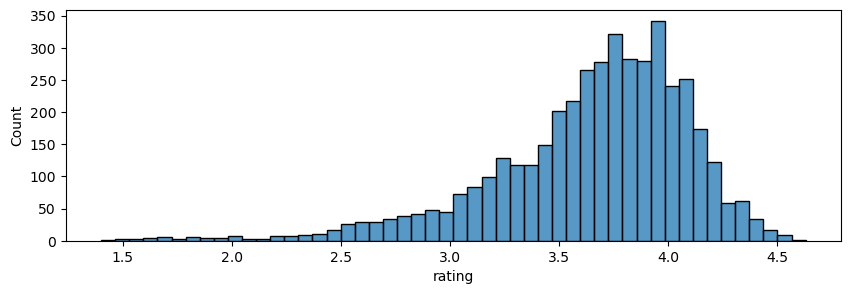

In [5]:
plt.figure(figsize=(10,3))
sns.histplot(data=df[df['votes']>100], x='rating')

<Axes: xlabel='votes', ylabel='Count'>

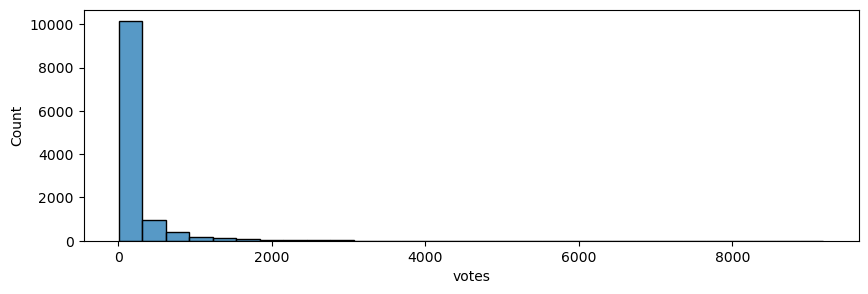

In [6]:
plt.figure(figsize=(10,3))
sns.histplot(data=df, x='votes', bins=30)

In [17]:
df[df['votes']>=20].shape

(9380, 10)

In [20]:
df[df['votes']>=20].artist.nunique()

3823

In [44]:
votes = 20

print(f"{df[df['votes']>=votes].shape[0]} of {df.shape[0]} albums have more than {votes} votes")
print(f"This represents {round(df[df['votes']>=votes].shape[0] / df.shape[0] *100, 2)} % of the albums")

9380 of 12059 albums have more than 20 votes
This represents 77.78 % of the albums


In [45]:
df_rock_ratings_20 = df[df['votes']>=20]
df_rock_ratings_20.shape

(9380, 10)

In [46]:
df_rock_ratings_20.head()

,year,artist,title,rating,votes,album_length,tracks,styles,release_country,artist_profile
0,2002,Sparta,Wiretap Scars,3.79,431,47.62,12,"['Indie Rock', 'Alternative Rock']",US,"El Paso, Texas based band. Formed in 2001 afte..."
1,2003,Muse,Absolution,3.99,4411,52.18,14,['Alternative Rock'],Europe,"Muse are an English rock band from Teignmouth,..."
2,1999,Muse,Showbiz,3.50,2181,49.65,12,"['Alternative Rock', 'Prog Rock']",UK,"Muse are an English rock band from Teignmouth,..."
3,2002,Finch,What It Is to Burn,3.69,864,61.18,13,"['Emo', 'Post-Hardcore', 'Alternative Rock']",US,"Finch is a post-hardcore band from Temecula, C..."
4,2002,Transplants,Transplants,3.35,198,45.23,12,['Punk'],US,"Punk rock/rap rock band Los Angeles, CA, Unite..."


In [47]:
df_rock_ratings_20.to_csv('Datasets/df_rock_ratings_20.csv', index=False)